<a href="https://colab.research.google.com/github/Doradux/IABD-Course/blob/main/PIA/tarea_con_redes_neuronales_recurrentes/finances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

In [2]:
ibex = yf.Ticker("^IBEX")
data = ibex.history(period="5y")
data.to_csv("ibex_1y.csv")

In [3]:
df = pd.read_csv("ibex_1y.csv", index_col="Date", parse_dates=True)
df.index = pd.to_datetime(df.index, utc=True)
df.index = df.index.tz_convert(None)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-29 22:00:00,6748.600098,6789.100098,6507.000000,6659.899902,232005200,0.0,0.0
2020-03-30 22:00:00,6746.799805,6802.000000,6624.700195,6785.399902,258181200,0.0,0.0
2020-03-31 22:00:00,6627.299805,6687.799805,6565.200195,6579.399902,235113700,0.0,0.0
2020-04-01 22:00:00,6633.700195,6658.899902,6424.500000,6574.100098,233309800,0.0,0.0
2020-04-02 22:00:00,6563.600098,6632.500000,6509.399902,6581.600098,215387500,0.0,0.0


In [4]:
df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [5]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1281.000000,1281.000000,1281.000000,1281.000000,1.281000e+03,1281.0,1281.0
mean,9171.620992,9231.256605,9111.027332,9174.474933,1.749995e+08,0.0,0.0
std,1509.301109,1511.207610,1514.052346,1514.895103,8.837630e+07,0.0,0.0
min,6351.399902,6461.600098,6329.500000,6411.799805,3.048230e+07,0.0,0.0
25%,8201.200195,8259.400391,8134.100098,8190.700195,1.202981e+08,0.0,0.0
50%,8915.900391,8959.900391,8853.000000,8906.400391,1.546361e+08,0.0,0.0
75%,9980.500000,10014.299805,9926.500000,9994.099609,2.038736e+08,0.0,0.0
max,13484.900391,13515.099609,13414.299805,13484.299805,9.752120e+08,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1281 entries, 2020-03-29 22:00:00 to 2025-03-27 23:00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1281 non-null   float64
 1   High          1281 non-null   float64
 2   Low           1281 non-null   float64
 3   Close         1281 non-null   float64
 4   Volume        1281 non-null   int64  
 5   Dividends     1281 non-null   float64
 6   Stock Splits  1281 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 80.1 KB


In [7]:
start_date = df.index.min()
end_date = df.index.max()
print("Desde:", start_date, "hasta:", end_date)

Desde: 2020-03-29 22:00:00 hasta: 2025-03-27 23:00:00


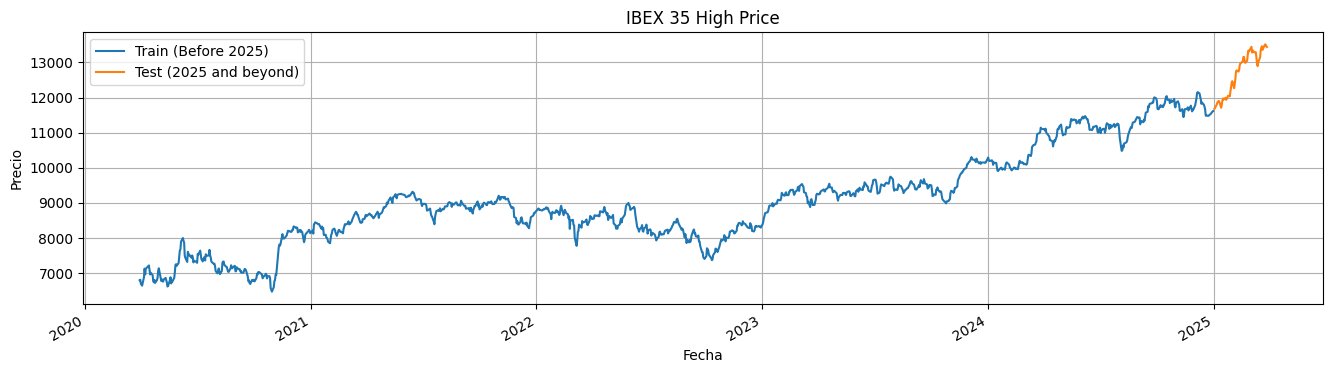

In [8]:
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)

tstart = 2020
tend = 2024

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("IBEX 35 High Price")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.grid(True)
    plt.show()

train_test_plot(df, tstart, tend)


In [10]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

In [11]:
sc = MinMaxScaler(feature_range=(0, 1))
# Hacer el reshape es necesario porque MinMaxScaler
# espera una entrada en forma de columnas, donde cada fila representa una muestra y cada columna una característica.
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [12]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)
print(X_train.shape)

(1159, 60, 1)


In [14]:
X_train

array([[[0.0575369 ],
        [0.05980322],
        [0.03973994],
        ...,
        [0.16958888],
        [0.18157064],
        [0.17204847]],

       [[0.05980322],
        [0.03973994],
        [0.03466265],
        ...,
        [0.18157064],
        [0.17204847],
        [0.14655653]],

       [[0.03973994],
        [0.03466265],
        [0.03002458],
        ...,
        [0.17204847],
        [0.14655653],
        [0.15518269]],

       ...,

       [[0.91600498],
        [0.91403727],
        [0.91475768],
        ...,
        [0.88327486],
        [0.8807626 ],
        [0.88265997]],

       [[0.91403727],
        [0.91475768],
        [0.93457494],
        ...,
        [0.8807626 ],
        [0.88265997],
        [0.89072381]],

       [[0.91475768],
        [0.93457494],
        [0.92640558],
        ...,
        [0.88265997],
        [0.89072381],
        [0.90281109]]])

## Modelo LSTM

In [16]:
!pip install scikeras

In [20]:
!pip install -U scikit-learn

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

def build_and_train_model(units, optimizer, batch_size, epochs):
    np.random.seed(455)
    tf.random.set_seed(455)

    model = Sequential()
    model.add(LSTM(units=units, activation="tanh", input_shape=(n_steps, features)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    return model

In [28]:
from sklearn.metrics import mean_squared_error

param_grid = {
    'units': [50, 100, 125],
    'optimizer': ['adam', 'RMSprop'],
    'batch_size': [16, 32],
    'epochs': [30, 50]
}

best_rmse = float("inf")
best_params = None
best_model = None

for units in param_grid['units']:
    for optimizer in param_grid['optimizer']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                print(f"Probando: units={units}, optimizer={optimizer}, batch_size={batch_size}, epochs={epochs}")
                model = build_and_train_model(units, optimizer, batch_size, epochs)
                predictions = model.predict(X_train, verbose=0)
                rmse = np.sqrt(mean_squared_error(y_train, predictions))
                print(f"RMSE: {rmse:.4f}")

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (units, optimizer, batch_size, epochs)
                    best_model = model

print("\nMejores hiperparámetros encontrados:")
print(f"units={best_params[0]}, optimizer={best_params[1]}, batch_size={best_params[2]}, epochs={best_params[3]}")
print(f"RMSE en train: {best_rmse:.4f}")

Probando: units=50, optimizer=adam, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0202
Probando: units=50, optimizer=adam, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0161
Probando: units=50, optimizer=adam, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0270
Probando: units=50, optimizer=adam, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0224
Probando: units=50, optimizer=RMSprop, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0206
Probando: units=50, optimizer=RMSprop, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0186
Probando: units=50, optimizer=RMSprop, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0208
Probando: units=50, optimizer=RMSprop, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0187
Probando: units=100, optimizer=adam, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0179
Probando: units=100, optimizer=adam, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0152
Probando: units=100, optimizer=adam, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0233
Probando: units=100, optimizer=adam, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0201
Probando: units=100, optimizer=RMSprop, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0206
Probando: units=100, optimizer=RMSprop, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0192
Probando: units=100, optimizer=RMSprop, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0199
Probando: units=100, optimizer=RMSprop, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0179
Probando: units=125, optimizer=adam, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0190
Probando: units=125, optimizer=adam, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0157
Probando: units=125, optimizer=adam, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0224
Probando: units=125, optimizer=adam, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0220
Probando: units=125, optimizer=RMSprop, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0203
Probando: units=125, optimizer=RMSprop, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0194
Probando: units=125, optimizer=RMSprop, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0191
Probando: units=125, optimizer=RMSprop, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0182

Mejores hiperparámetros encontrados:
units=100, optimizer=adam, batch_size=16, epochs=50
RMSE en train: 0.0152


In [29]:
# Preparar X_test otra vez si hace falta
dataset_total = df.loc[:, "High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

# Predecir con el mejor modelo
predicted_stock_price = best_model.predict(X_test, verbose=0)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


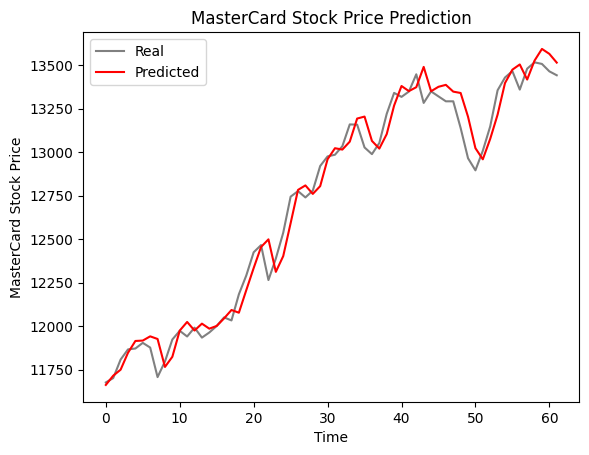

The root mean squared error is 95.09.


In [32]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

# Mostramos los resultados
plot_predictions(test_set, predicted_stock_price)
return_rmse(test_set, predicted_stock_price)


## Modelo GRU

In [33]:
from tensorflow.keras.layers import GRU
from tqdm import tqdm  # mostrar el progreso bonito

def build_and_train_model(units, optimizer, batch_size, epochs):
    np.random.seed(455)
    tf.random.set_seed(455)

    model = Sequential()
    model.add(GRU(units=units, activation="tanh", input_shape=(n_steps, features)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    return model

In [36]:
from sklearn.metrics import mean_squared_error

param_grid = {
    'units': [50, 100, 125],
    'optimizer': ['adam', 'RMSprop'],
    'batch_size': [16, 32],
    'epochs': [30, 50]
}

combinations = [
    (u, o, b, e)
    for u in param_grid['units']
    for o in param_grid['optimizer']
    for b in param_grid['batch_size']
    for e in param_grid['epochs']
]

best_rmse = float("inf")
best_params = None
best_model = None

print(f"\nProbando {len(combinations)} combinaciones...\n")

for i, (units, optimizer, batch_size, epochs) in enumerate(tqdm(combinations), 1):
    print(f"\n{i}/{len(combinations)} - units={units}, optimizer={optimizer}, batch_size={batch_size}, epochs={epochs}")
    model = build_and_train_model(units, optimizer, batch_size, epochs)
    predictions = model.predict(X_train, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_train, predictions))
    print(f"   RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (units, optimizer, batch_size, epochs)
        best_model = model

print("\nMejores hiperparámetros encontrados:")
print(f"units={best_params[0]}, optimizer={best_params[1]}, batch_size={best_params[2]}, epochs={best_params[3]}")
print(f"RMSE en train: {best_rmse:.4f}")


Probando 24 combinaciones...



  0%|          | 0/24 [00:00<?, ?it/s]


1/24 - units=50, optimizer=adam, batch_size=16, epochs=30


  4%|▍         | 1/24 [01:21<31:09, 81.29s/it]

   RMSE: 0.0155

2/24 - units=50, optimizer=adam, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
  8%|▊         | 2/24 [03:32<40:29, 110.44s/it]

   RMSE: 0.0148

3/24 - units=50, optimizer=adam, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 12%|█▎        | 3/24 [04:15<27:57, 79.88s/it] 

   RMSE: 0.0164

4/24 - units=50, optimizer=adam, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 17%|█▋        | 4/24 [05:27<25:37, 76.85s/it]

   RMSE: 0.0159

5/24 - units=50, optimizer=RMSprop, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 21%|██        | 5/24 [06:44<24:18, 76.78s/it]

   RMSE: 0.0202

6/24 - units=50, optimizer=RMSprop, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 25%|██▌       | 6/24 [08:51<28:07, 93.76s/it]

   RMSE: 0.0204

7/24 - units=50, optimizer=RMSprop, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 29%|██▉       | 7/24 [09:34<21:53, 77.28s/it]

   RMSE: 0.0209

8/24 - units=50, optimizer=RMSprop, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 33%|███▎      | 8/24 [10:43<19:54, 74.66s/it]

   RMSE: 0.0165

9/24 - units=100, optimizer=adam, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 38%|███▊      | 9/24 [12:19<20:19, 81.32s/it]

   RMSE: 0.0155

10/24 - units=100, optimizer=adam, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 42%|████▏     | 10/24 [14:55<24:21, 104.37s/it]

   RMSE: 0.0150

11/24 - units=100, optimizer=adam, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 46%|████▌     | 11/24 [16:10<20:38, 95.30s/it] 

   RMSE: 0.0179

12/24 - units=100, optimizer=adam, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 50%|█████     | 12/24 [18:03<20:08, 100.68s/it]

   RMSE: 0.0154

13/24 - units=100, optimizer=RMSprop, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 54%|█████▍    | 13/24 [19:41<18:19, 99.94s/it] 

   RMSE: 0.0222

14/24 - units=100, optimizer=RMSprop, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 58%|█████▊    | 14/24 [22:15<19:23, 116.32s/it]

   RMSE: 0.0212

15/24 - units=100, optimizer=RMSprop, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 62%|██████▎   | 15/24 [23:22<15:12, 101.41s/it]

   RMSE: 0.0178

16/24 - units=100, optimizer=RMSprop, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 67%|██████▋   | 16/24 [25:19<14:07, 105.95s/it]

   RMSE: 0.0166

17/24 - units=125, optimizer=adam, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 71%|███████   | 17/24 [27:45<13:47, 118.21s/it]

   RMSE: 0.0160

18/24 - units=125, optimizer=adam, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 75%|███████▌  | 18/24 [31:52<15:40, 156.73s/it]

   RMSE: 0.0155

19/24 - units=125, optimizer=adam, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 79%|███████▉  | 19/24 [33:10<11:06, 133.27s/it]

   RMSE: 0.0169

20/24 - units=125, optimizer=adam, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 83%|████████▎ | 20/24 [35:40<09:13, 138.34s/it]

   RMSE: 0.0158

21/24 - units=125, optimizer=RMSprop, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 88%|████████▊ | 21/24 [37:47<06:44, 134.79s/it]

   RMSE: 0.0218

22/24 - units=125, optimizer=RMSprop, batch_size=16, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 92%|█████████▏| 22/24 [41:48<05:33, 166.73s/it]

   RMSE: 0.0214

23/24 - units=125, optimizer=RMSprop, batch_size=32, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 96%|█████████▌| 23/24 [43:17<02:23, 143.42s/it]

   RMSE: 0.0173

24/24 - units=125, optimizer=RMSprop, batch_size=32, epochs=50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
100%|██████████| 24/24 [45:41<00:00, 114.21s/it]

   RMSE: 0.0166

Mejores hiperparámetros encontrados:
units=50, optimizer=adam, batch_size=16, epochs=50
RMSE en train: 0.0148


In [37]:
# Preparar X_test
dataset_total = df.loc[:, "High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

# Predecir con el mejor modelo GRU
predicted_stock_price = best_model.predict(X_test, verbose=0)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

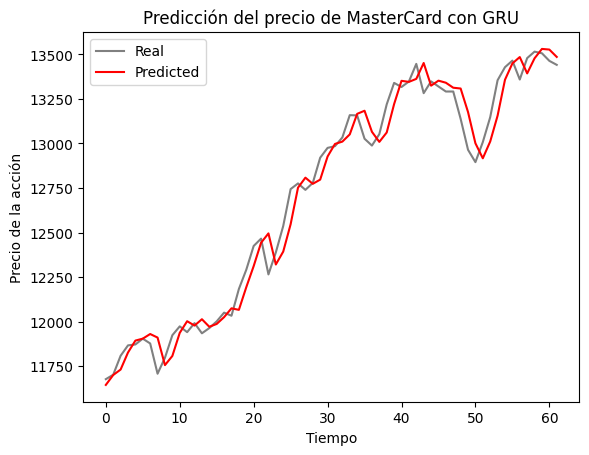

El RMSE (error cuadrático medio) es 96.11


In [38]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Predicción del modelo")
    plt.xlabel("Tiempo")
    plt.ylabel("Precio de la acción")
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("El RMSE (error cuadrático medio) es {:.2f}".format(rmse))

# Mostrar resultados
plot_predictions(test_set, predicted_stock_price)
return_rmse(test_set, predicted_stock_price)


## Usando la API

In [43]:
from tensorflow import keras
from tensorflow.keras import layers
import random

# Semillas fijas para reproducibilidad
np.random.seed(455)
tf.random.set_seed(455)
random.seed(455)

# Mejores hiperparámetros encontrados
best_units = 100
best_optimizer = 'adam'
best_batch_size = 16
best_epochs = 50

# Definir la entrada
inputs = keras.Input(shape=(n_steps, features))

# Capa LSTM
x = layers.LSTM(units=best_units, activation="tanh")(inputs)

# Capa de salida
outputs = layers.Dense(units=1)(x)

# Crear modelo
model_lstm = keras.Model(inputs=inputs, outputs=outputs)

# Compilar modelo
model_lstm.compile(optimizer=best_optimizer, loss="mse")

# Mostrar resumen
model_lstm.summary()

Model: "functional_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)          │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model_lstm.fit(X_train, y_train, batch_size=best_batch_size, epochs=best_epochs, verbose=1)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0863
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0014
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0012
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0012
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0011
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0010
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0010
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 9.6312e-04
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.2690e-04
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.9132e-04
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.5648e-04
Epoch 13/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 8.2259e-04
Epoch 14/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.8980e-04
Epoch 15/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


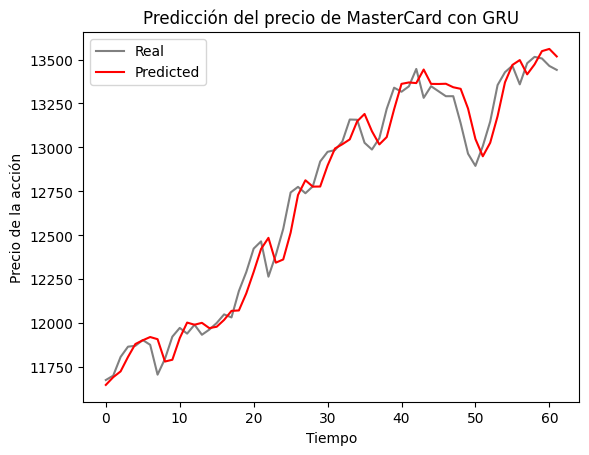

El RMSE (error cuadrático medio) es 103.10


In [45]:
# Predecir
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Mostrar resultados
plot_predictions(test_set, predicted_stock_price)
return_rmse(test_set, predicted_stock_price)